In [1]:
#Load Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,func

In [2]:
#Create database engine
engine=create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
#Reflect an existing database into a new model
Base=automap_base()

#Reflect the tables
Base.prepare(engine,reflect=True)

In [4]:
#View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
#Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [6]:
#Create session (link) from Python to the DB
session=Session(engine)

# Exploratory Climate Analysis

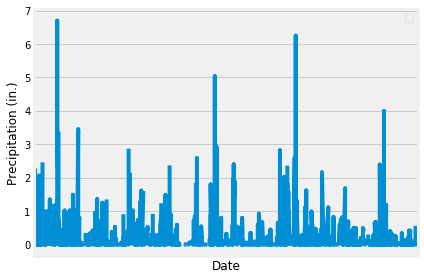

In [7]:
#Design a query to retrieve the last 12 months of precipitation data and plot the results
#Calculate the date 1 year ago from the last data point in the database
lastdate=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
lastdate=lastdate[0]
lastdate=dt.datetime.strptime(lastdate,'%Y-%m-%d').date()
querydate=lastdate-dt.timedelta(days=365)

#Perform a query to retrieve the data and precipitation scores
precipdata=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=querydate).all()

#Save the query results as a Pandas DataFrame and set the index to the date column
precip=pd.DataFrame(precipdata,columns=['date','precip'])
precip['date']=pd.to_datetime(precip['date'])
precip.set_index('date',inplace=True)

#Sort the dataframe by date
precip.sort_index(axis=0,inplace=True)

#Use Pandas Plotting with Matplotlib to plot the data
precip.plot(y='precip')
plt.xticks([])
plt.xlabel('Date')
plt.ylabel('Precipitation (in.)')
plt.legend('')
plt.tight_layout()
plt.savefig('images/precipitation.png')

In [8]:
#Use Pandas to calculate the summary statistics for the precipitation data
precip.describe()

,precip
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [9]:
#Design a query to show how many stations are available in this dataset?
stations=session.query(Measurement.station.distinct()).count()
print(f'There are {stations} stations in the dataset.')

There are 9 stations in the dataset.


In [10]:
#What are the most active stations? (i.e. what stations have the most rows)?
#List the stations and the counts in descending order.
active=session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [11]:
#Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature of the most active station?
activetobs=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
activetobs

[(54.0, 85.0, 71.66378066378067)]

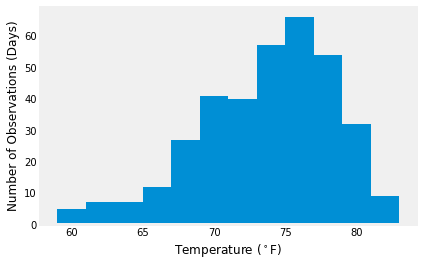

In [12]:
#Choose the station with the highest number of temperature observations.
#Query the last 12 months of temperature observation data for this station
activedate=session.query(Measurement.date).order_by(Measurement.date.desc()).filter(Measurement.station=='USC00519281').first()
activedate=activedate[0]
activedate=dt.datetime.strptime(activedate,'%Y-%m-%d').date()
activequerydate=activedate-dt.timedelta(days=365)

#Perform a query to retrieve the data and temperature observations
activedata=session.query(Measurement.date,Measurement.prcp,Measurement.tobs).filter(Measurement.date>=activequerydate).filter(Measurement.station=='USC00519281').all()

#Save the query results as a Pandas DataFrame
active=pd.DataFrame(activedata,columns=['date','prcp','tobs'])

#Plot the results as a histogram
active.hist(column='tobs',bins=12,grid=False)
plt.title('')
plt.xlabel('Temperature ($^\circ$F)')
plt.ylabel('Number of Observations (Days)')
plt.savefig('images/stationtemperaturehistogram.png')

In [13]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date,end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs)).\
        filter(Measurement.date>=start_date).filter(Measurement.date<=end_date).all()

# function usage example
print(calc_temps('2012-02-28','2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [14]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax for your trip using the previous year's data for those same dates.
triptemps=calc_temps('2016-12-27','2017-01-05')
triptemps

[(62.0, 69.63934426229508, 77.0)]

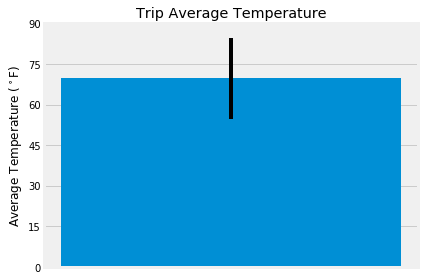

In [15]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(1,triptemps[0][1],yerr=(triptemps[0][2]-triptemps[0][0]))
plt.xticks([])
plt.yticks(np.arange(0,91,15))
plt.xlabel('')
plt.ylabel('Average Temperature ($^\circ$F)')
plt.title('Trip Average Temperature')
plt.tight_layout()
plt.savefig('images/triptemp.png')

In [16]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain=session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).\
    group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).filter(Measurement.station==Station.station).\
    filter(Measurement.date>='2016-12-27').filter(Measurement.date<='2017-01-05').all()
rain

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  5.08),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.42),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.3),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.2500000000000002),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.78),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.19),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [17]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]